In [1]:
import pandas as pd
import numpy as np
from dotenv import dotenv_values, find_dotenv
import matplotlib.pyplot as plt
import os
config = dotenv_values(find_dotenv())
path_cleandata = os.path.abspath(config["CLEANDATA"]) + '\\'
path_figures = os.path.abspath(config["FIGURES"]) + '\\'

In [36]:
# import my merged data
data = pd.read_pickle(path_cleandata + 'BEA6_naics6_merged.pkl')

In [37]:
# filter for the year 2017 
data2017 = data[data['date'].dt.year == 2017]

In [38]:
# personal consumption expenditures
data2017 = data2017[data2017['product_O'].str.contains('Personal consumption expenditures')][['product_I', 'date', 'IO_value', 'expenditures_I']]

In [39]:
# sum by product for that year
# first groupby: take sum of IO_value and mean of expenditures_I by date and product
byproduct = data2017.groupby(['product_I']).agg({
    'IO_value': 'mean',
    'expenditures_I': 'mean'}, min_count=1).reset_index()


In [40]:
byproduct.set_index('product_I')[['IO_value', 'expenditures_I']].sum(axis=0)

IO_value          11840523.0
expenditures_I    13756277.0
dtype: float64

## taking a look at how well the merge worked

In [41]:
# create distance variable
byproduct['distance'] = np.abs(byproduct['IO_value'] - byproduct['expenditures_I'])

# kinda "outliers" that have a very different value
outlier_threshold = 75000

# Filter only the points that are outliers
outliers = byproduct[byproduct['distance'] > outlier_threshold]

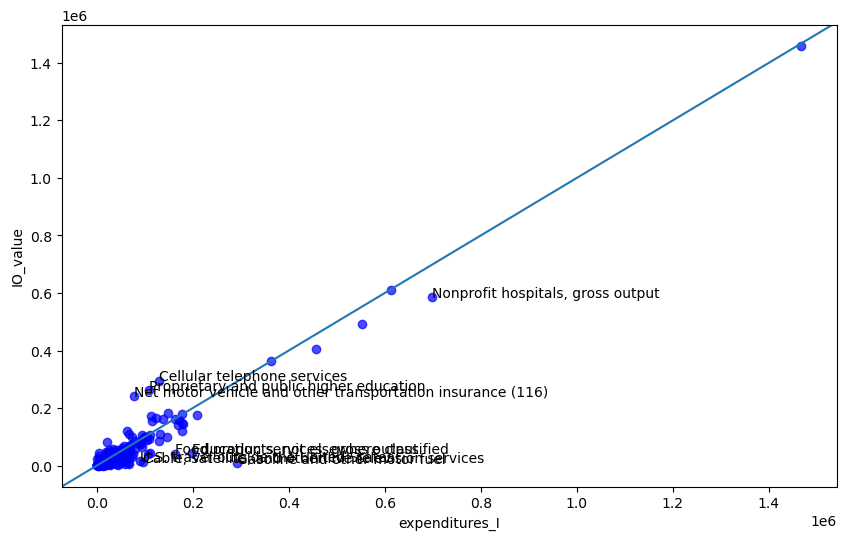

In [42]:
# do the scatter plot with expenditures on the x axis

plt.figure(figsize=(10, 6))
plt.scatter(byproduct['expenditures_I'], byproduct['IO_value'], c='blue', alpha=0.7)

plt.xlabel('expenditures_I')
plt.ylabel('IO_value')

ax = plt.gca()
ax.axline((0, 0), slope=1)

for idx, row in byproduct.iterrows():
    if byproduct['product_I'][idx] in list(set(outliers['product_I'])):
        plt.annotate(byproduct['product_I'][idx], (byproduct['expenditures_I'][idx], byproduct['IO_value'][idx]))

plt.savefig(path_figures + 'merge_check\\expenditures.pdf')

In [43]:
# this is the list of "outlier" products: issues mostly come from housing and healthcare type stuff
# noting the 2017 expenditures for tenant-occupied stationary houses is 0: having trouble getting min_count to work (actually all NaNs)
# within the merge, foreign travel in the United States gets matched with the rest-of-world adjustment in the IO table, which i should probably get rid of
outliers

,product_I,IO_value,expenditures_I,distance
13,"Cable, satellite, and other live television se...",11002.621674,96011.00,85008.378326
17,Cellular telephone services,295023.328101,130412.25,164611.078101
37,"Education services, gross output",42077.272514,198067.25,155989.977486
52,"Food products, not elsewhere classified",40848.000000,161953.75,121105.750000
63,Gasoline and other motor fuel,7647.119287,291553.50,283906.380713
112,Net motor vehicle and other transportation ins...,241597.801823,77603.00,163994.801823
122,"Nonprofit hospitals, gross output",584226.560581,698362.00,114135.439419
162,Proprietary and public higher education,261107.082032,107830.00,153277.082032
199,U.S. travel outside the United States,14323.162778,90876.00,76552.837222


In [44]:
# go into concordance, which shows some of the issues

concordance = pd.read_pickle(path_cleandata + 'concordance//concordance6_naics6_addproportions.pkl')
outlierproducts = list(outliers['product_I'])

outliermerges = concordance[concordance['product'].isin(outlierproducts)]
outliermerges

,product,NAICS_desc,IO_proportions
15,Gasoline and other motor fuel,Motor vehicle gasoline engine and engine parts...,0.943623
16,Gasoline and other motor fuel,Oil and gas extraction,0.943623
17,Gasoline and other motor fuel,Drilling oil and gas wells,1.000000
44,Proprietary and public higher education,"Junior colleges, colleges, universities, and p...",1.000000
45,Proprietary and public higher education,Other educational services,0.326914
46,Proprietary and public higher education,Educational and vocational structures,0.635854
79,"Cable, satellite, and other live television se...",Radio and television broadcasting,0.593088
80,"Cable, satellite, and other live television se...",Cable and other subscription programming,0.690302
81,"Cable, satellite, and other live television se...","Satellite, telecommunications resellers, and a...",0.303401
114,"Nonprofit hospitals, gross output",Hospitals,0.562191


c:\Users\EmilyFu\.conda\envs\myenv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


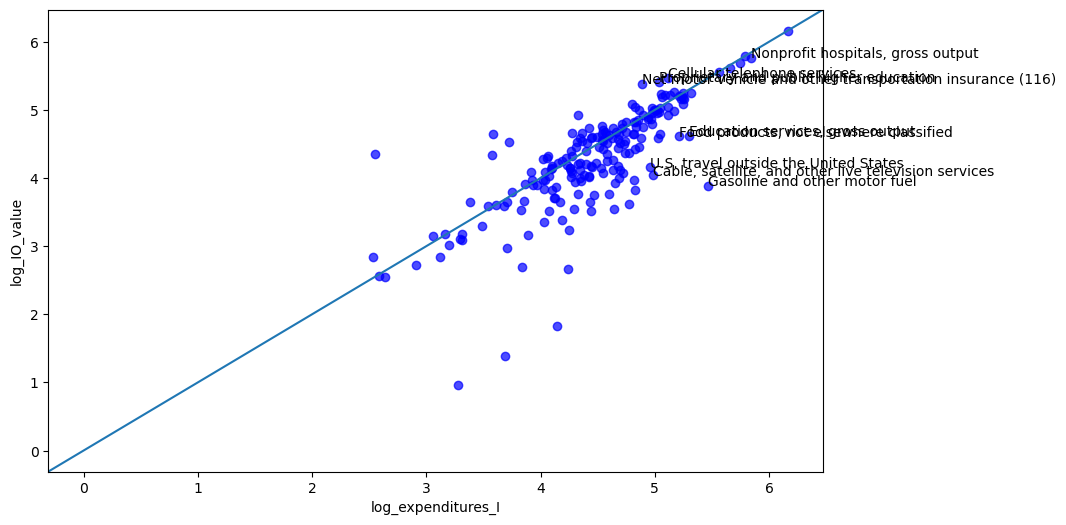

In [45]:
# get logs of everything and do an equivalent scatter plot with those

# do the scatter plot with expenditures on the x axis 
# do a base 10 log
plt.figure(figsize=(10, 6))
plt.scatter(np.log10(byproduct['expenditures_I']), np.log10(byproduct['IO_value']), c='blue', alpha=0.7)

plt.xlabel('log_expenditures_I')
plt.ylabel('log_IO_value')

ax = plt.gca()
ax.axline((0, 0), slope=1)


for idx, row in byproduct.iterrows():
    if byproduct['product_I'][idx] in list(set(outliers['product_I'])):
        plt.annotate(byproduct['product_I'][idx], (np.log10(byproduct['expenditures_I'])[idx], np.log10(byproduct['IO_value'])[idx]))

plt.savefig(path_figures + 'merge_check\\log_expenditures.pdf')
